<a href="https://colab.research.google.com/github/ranandrajrnd/mithanet/blob/main/Working_mithanet_gb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Working code**

In [ ]:
# System libs for GRIB + required Python packages
!apt-get -y update >/dev/null
!apt-get -y install -qq libeccodes0 libeccodes-dev >/dev/null

# Colab-friendly pins (ERA5 client 0.4.0 is the latest Colab sees)
!pip -q install \
  earthaccess xarray netcdf4 rioxarray rasterio h5netcdf h5py \
  "ecmwf-datastores-client==0.4.0" eccodes cfgrib \
  srtm.py xesmf \
  "fsspec[http]==2025.3.0" "gcsfs==2025.3.0" "tenacity<9"

import os, sys


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import os, warnings, numpy as np, matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timezone, timedelta
warnings.filterwarnings("ignore")

# Workspace
WORK_DIR = "/content/mithanet_hindcast"
os.makedirs(WORK_DIR, exist_ok=True)

# Event & region
YEAR, MONTH, DAY = 2025, 8, 30
# BBOX for Chennai (lon_min, lat_min, lon_max, lat_max)
BBOX = (79.9, 12.8, 80.6, 13.9)
# Event point (approx)
EVENT_LAT, EVENT_LON = 13.16, 80.26

# Mini-cloudburst threshold definition (truth)
THRESH_MM_HR = 50.0

def julian_day(y,m,d):
    return datetime(y,m,d).timetuple().tm_yday

print(f"MiTHANet Hindcast — {YEAR}-{MONTH:02d}-{DAY:02d}  JDAY={julian_day(YEAR,MONTH,DAY)}  BBOX={BBOX}")


MiTHANet Hindcast — 2025-08-30  JDAY=242  BBOX=(79.9, 12.8, 80.6, 13.9)


In [ ]:
import getpass, earthaccess, os

print("Enter your NASA Earthdata credentials for GES DISC (required for IMERG).")
#ea_user = input("Earthdata username: ").strip()
#ea_pass = getpass.getpass("Earthdata password: ").strip()

ea_user = "ranandraj@gmail.com"
ea_pass = "Mymeace@2025"
# Write ~/.netrc so redirects to urs & gesdisc work
netrc_path = os.path.expanduser("~/.netrc")
with open(netrc_path, "w") as f:
    f.write(
f"""machine urs.earthdata.nasa.gov
  login {ea_user}
  password {ea_pass}
machine gpm1.gesdisc.eosdis.nasa.gov
  login {ea_user}
  password {ea_pass}
machine disc.gsfc.nasa.gov
  login {ea_user}
  password {ea_pass}
""")
os.chmod(netrc_path, 0o600)

earthaccess.login(strategy="netrc")
print("NASA Earthdata login set.")


Enter your NASA Earthdata credentials for GES DISC (required for IMERG).
NASA Earthdata login set.


In [ ]:
start = f"{YEAR}-{MONTH:02d}-{DAY:02d} 00:00:00"
end   = f"{YEAR}-{MONTH:02d}-{DAY:02d} 23:59:59"

late = earthaccess.search_data(short_name="GPM_3IMERGHHL", version="07",
                               temporal=(start, end), bounding_box=BBOX)
early = earthaccess.search_data(short_name="GPM_3IMERGHHE", version="07",
                                temporal=(start, end), bounding_box=BBOX)

print("IMERG Late hits:", len(late))
print("IMERG Early hits:", len(early))
if not len(late) and not len(early):
    raise SystemExit("No IMERG granules found. Check credentials/bbox/date or widen bbox/time.")

def granule_begin_dt(item):
    try:
        t = item["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"]
        return datetime.fromisoformat(t.replace("Z","+00:00")).astimezone(timezone.utc)
    except Exception:
        return None

def pick_evening(granules, start_hour=16, end_hour=20, limit=12):
    gt = [(g, granule_begin_dt(g)) for g in granules]
    gt = [(g,t) for g,t in gt if t is not None]
    sel = [g for g,t in gt if start_hour <= t.hour <= end_hour]
    if not sel:
        sel = [g for g,_ in sorted(gt, key=lambda x: x[1])[:limit]] if gt else granules[:limit]
    return sel[:limit]

chosen = late if len(late) else early
label  = "Late" if len(late) else "Early"
sel    = pick_evening(chosen, 16, 20, 12)
print(f"Selected {len(sel)} {label} granules for download (evening UTC window).")


IMERG Late hits: 48
IMERG Early hits: 48
Selected 10 Late granules for download (evening UTC window).


In [ ]:
imerg_dir = f"{WORK_DIR}/IMERG_{label}"
os.makedirs(imerg_dir, exist_ok=True)

dl_paths = earthaccess.download(sel, imerg_dir)
dl_paths = [p for p in dl_paths if p and p.lower().endswith(".hdf5")]
print("IMERG downloaded files:", len(dl_paths))
if not dl_paths:
    raise SystemExit("IMERG download failed (likely auth). Re-run Cell 3, then this cell.")


QUEUEING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/10 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/10 [00:00<?, ?it/s]

IMERG downloaded files: 10


In [ ]:
import h5py

def _find_first(h5, paths):
    for p in paths:
        if p in h5: return p
    return None

def _list_precip_like(h5):
    hits=[]
    def walk(g, base=""):
        for k,v in g.items():
            p = f"{base}/{k}" if base else f"/{k}"
            if isinstance(v, h5py.Dataset):
                if "precip" in k.lower(): hits.append(p)
            elif isinstance(v, h5py.Group):
                walk(v, p)
    walk(h5, ""); return hits

def _get_attr(dset, names, default=None):
    for n in names:
        if n in dset.attrs: return dset.attrs[n]
    return default

def open_imerg_hdf5(fp):
    with h5py.File(fp, "r") as h5:
        pp = _find_first(h5, [
            "/Grid/precipitationCal","/Grid/precipitation",
            "/Grid/precipitationRate","/Grid/HQprecipitation","/Grid/IRprecipitation"
        ])
        if pp is None:
            cands = sorted(_list_precip_like(h5),
                           key=lambda s:(0 if s.startswith("/Grid") else 1,
                                         0 if "cal" in s.lower() else 1, len(s)))
            pp = cands[0] if cands else None
        if pp is None:
            raise RuntimeError(f"No precipitation dataset in {os.path.basename(fp)}")

        d = h5[pp]; data = d[()].astype(np.float32, copy=False)
        fill = _get_attr(d, ["_FillValue","missing_value","MissingValue"], None)
        scale = _get_attr(d, ["scale_factor","ScaleFactor"], 1.0)
        offset= _get_attr(d, ["add_offset","AddOffset"], 0.0)
        if fill is not None: data = np.where(data == fill, np.nan, data)
        if (scale not in (None,1.0)) or (offset not in (None,0.0)):
            data = data * (scale if scale is not None else 1.0) + (offset if offset is not None else 0.0)
        while data.ndim > 2: data = data[0,...]
        if data.ndim != 2:
            raise RuntimeError(f"Unexpected precip shape {data.shape}")

        # coords
        latp = _find_first(h5, ["/Grid/lat","/lat","/HDFEOS/GRIDS/Precipitation/lat","/HDFEOS/GRIDS/Precipitation Grid/lat"])
        lonp = _find_first(h5, ["/Grid/lon","/lon","/HDFEOS/GRIDS/Precipitation/lon","/HDFEOS/GRIDS/Precipitation Grid/lon"])

        if latp and lonp:
            latv = h5[latp][()]; lonv = h5[lonp][()]
            if latv.ndim == 2 and lonv.ndim == 2 and latv.shape == data.shape:
                da = xr.DataArray(data, dims=("y","x"), name="precipitation").assign_coords(
                    lat=(("y","x"), latv), lon=(("y","x"), lonv))
            elif latv.ndim == 1 and lonv.ndim == 1 and (latv.size, lonv.size) == data.shape:
                da = xr.DataArray(data, dims=("lat","lon"), coords={"lat":latv,"lon":lonv}, name="precipitation")
            else:
                da = xr.DataArray(data, dims=("y","x"), name="precipitation")
        else:
            # heuristic 0.1° global IMERG grid
            ny, nx = data.shape
            lats_1d = 89.95 - 0.1 * np.linspace(0, 1799, ny)
            lons_1d = -179.95 + 0.1 * np.linspace(0, 3599, nx)
            LAT, LON = np.meshgrid(lats_1d, lons_1d, indexing="ij")
            da = xr.DataArray(data, dims=("y","x"), name="precipitation").assign_coords(
                lat=(("y","x"), LAT), lon=(("y","x"), LON))

        da.attrs["units"] = _get_attr(d, ["units","Units"], "mm/hr")
        da.attrs["source_path"] = pp
        return da

def ensure_latlon2d(da: xr.DataArray) -> xr.DataArray:
    if ("lat" in da.coords and "lon" in da.coords and
        da["lat"].ndim == 2 and da["lon"].ndim == 2 and da["lat"].shape == da.shape):
        return da
    if "lat" in da.coords and "lon" in da.coords and da["lat"].ndim == 1 and da["lon"].ndim == 1:
        LAT, LON = np.meshgrid(da["lat"].values, da["lon"].values, indexing="ij")
        if da.dims == ("lat","lon"):
            return da.assign_coords(lat=(("lat","lon"), LAT), lon=(("lat","lon"), LON))
        else:
            da2 = da.rename({da.dims[0]:"lat", da.dims[1]:"lon"})
            return da2.assign_coords(lat=(("lat","lon"), LAT), lon=(("lat","lon"), LON))
    # heuristic fallback to global 0.1° grid
    ny, nx = da.shape
    lats_1d = 89.95 - 0.1 * np.linspace(0, 1799, ny)
    lons_1d = -179.95 + 0.1 * np.linspace(0, 3599, nx)
    LAT, LON = np.meshgrid(lats_1d, lons_1d, indexing="ij")
    if da.dims != ("y","x"):
        da = da.rename({da.dims[0]:"y", da.dims[1]:"x"})
    return da.assign_coords(lat=(("y","x"), LAT), lon=(("y","x"), LON))


In [ ]:
from pathlib import Path
import re

def parse_start_time_from_name(p: str):
    # e.g., ...S160000-E162959....
    m = re.search(r"S(\d{2})(\d{2})(\d{2})", os.path.basename(p))
    if not m: return None
    hh, mm, ss = map(int, m.groups())
    return hh, mm, ss

pairs = []           # (hhmmss, DataArray)
times_utc = []       # begin time per frame (UTC, datetime)
files_kept = []      # file names (for debugging)

for fp in sorted(dl_paths):
    try:
        hhmmss = parse_start_time_from_name(fp)
        da = open_imerg_hdf5(fp)
        if hhmmss:
            pairs.append((hhmmss, da))
            t0 = datetime(YEAR, MONTH, DAY, hhmmss[0], hhmmss[1], hhmmss[2], tzinfo=timezone.utc)
            times_utc.append(t0)
            files_kept.append(os.path.basename(fp))
    except Exception as e:
        print("IMERG read failed:", os.path.basename(fp), "->", e)

# sort consistently
pairs, times_utc, files_kept = zip(*sorted(zip(pairs, times_utc, files_kept), key=lambda x: x[1]))
imerg_frames = [p[1] for p in pairs]
print("IMERG frames read (evening window):", len(imerg_frames))
print("First/last UTC times:", times_utc[0], "→", times_utc[-1])


IMERG frames read (evening window): 10
First/last UTC times: 2025-08-30 16:00:00+00:00 → 2025-08-30 20:30:00+00:00


In [ ]:
# Compute max rain in the bbox for each granule and test threshold (≥50 mm/hr)
peaks = [float(np.nanmax(ensure_latlon2d(fr).values)) for fr in imerg_frames]
event_hit = any(p >= THRESH_MM_HR for p in peaks)
print("Max intensity per 30-min granule (mm/hr):", peaks)
print(f"Mini-cloudburst exceedance (≥{THRESH_MM_HR} mm/hr) present? ->", event_hit)

# Nearest grid to event point
ref = ensure_latlon2d(imerg_frames[-1])
D = (ref["lat"] - EVENT_LAT)**2 + (ref["lon"] - EVENT_LON)**2
iy, ix = np.unravel_index(np.nanargmin(D.values), D.shape)

pt_series = [float(ensure_latlon2d(fr).values[iy, ix]) for fr in imerg_frames]
print("Nearest-cell time series at event point (mm/hr):", pt_series)

# Convert times to IST for plotting (UTC+5:30)
times_ist = [t + timedelta(hours=5, minutes=30) for t in times_utc]


Max intensity per 30-min granule (mm/hr): [50.23999786376953, 49.78999710083008, 49.15999984741211, 49.21999740600586, 52.599998474121094, 60.349998474121094, 57.46999740600586, 50.20000076293945, 58.48999786376953, 52.18000030517578]
Mini-cloudburst exceedance (≥50.0 mm/hr) present? -> True
Nearest-cell time series at event point (mm/hr): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


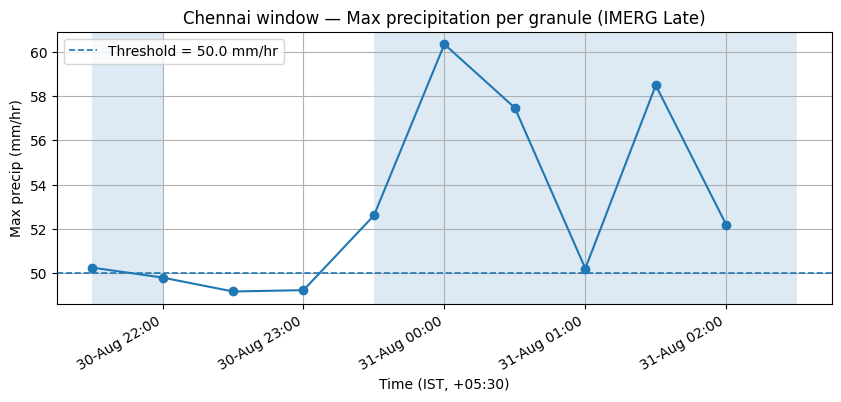

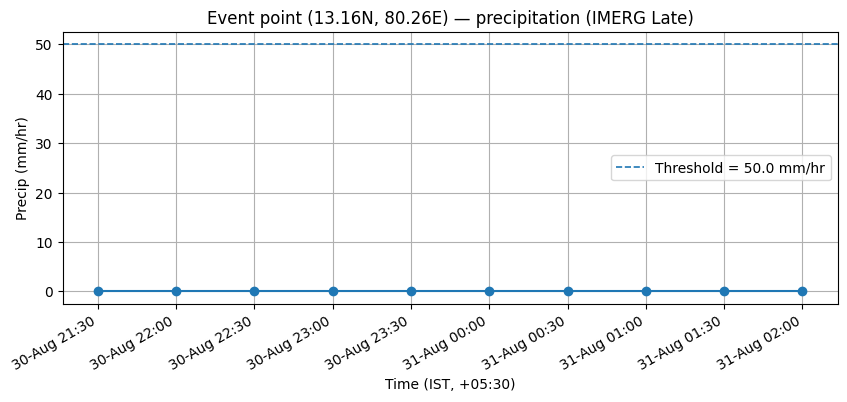

In [ ]:
import matplotlib.dates as mdates

def plot_time_series(times, series, threshold, title, ylabel):
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(times, series, marker='o')
    ax.axhline(threshold, linestyle='--', linewidth=1.2, label=f"Threshold = {threshold} mm/hr")
    # Shade exceedance intervals
    for t, val in zip(times, series):
        if val >= threshold:
            ax.axvspan(t, t + timedelta(minutes=30), alpha=0.15)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time (IST, +05:30)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
    fig.autofmt_xdate()
    ax.grid(True)
    ax.legend()
    plt.show()

plot_time_series(
    times_ist, peaks, THRESH_MM_HR,
    title=f"Chennai window — Max precipitation per granule (IMERG {label})",
    ylabel="Max precip (mm/hr)"
)

plot_time_series(
    times_ist, pt_series, THRESH_MM_HR,
    title=f"Event point ({EVENT_LAT:.2f}N, {EVENT_LON:.2f}E) — precipitation (IMERG {label})",
    ylabel="Precip (mm/hr)"
)


In [ ]:
from ecmwf.datastores import Client
import os

print("Paste your CDS API token (UUID from https://cds.climate.copernicus.eu/profile). Leave blank to skip ERA5.")
#cds_token = input("CDS token (UUID): ").strip()
cds_token = "22883c92-1c07-4fda-9975-278407840696"
era_grib = None
if cds_token:
    os.environ["ECMWF_DATASTORES_URL"] = "https://cds.climate.copernicus.eu/api"
    os.environ["ECMWF_DATASTORES_KEY"] = cds_token
    try:
        client = Client()
    except Exception:
        client = Client(url="https://cds.climate.copernicus.eu/api", key=cds_token)

    era_dir = f"{WORK_DIR}/ERA5"; os.makedirs(era_dir, exist_ok=True)
    era_grib = f"{era_dir}/era5_single_{YEAR}{MONTH:02d}{DAY:02d}_chennai.grib"
    if os.path.exists(era_grib):
        try: os.remove(era_grib)
        except OSError: pass

    request = {
        "product_type": ["reanalysis"],
        "variable": [
            "10m_u_component_of_wind","10m_v_component_of_wind",
            "convective_available_potential_energy",
            "2m_temperature","2m_dewpoint_temperature",
        ],
        "year":  [f"{YEAR:04d}"],
        "month": [f"{MONTH:02d}"],
        "day":   [f"{DAY:02d}"],
        "time":  [f"{h:02d}:00" for h in range(24)],
        "area":  [13.9, 79.9, 12.8, 80.6],   # N, W, S, E
        "format": "grib"
    }

    print("Submitting ERA5 request…")
    try:
        client.retrieve("reanalysis-era5-single-levels", request, target=era_grib)
        print("ERA5 GRIB saved ->", era_grib, "| size:", os.path.getsize(era_grib))
    except Exception as e:
        print("ERA5 retrieve failed:", e)
        era_grib = None
else:
    print("Skipping ERA5 download.")


Paste your CDS API token (UUID from https://cds.climate.copernicus.eu/profile). Leave blank to skip ERA5.
Submitting ERA5 request…


92e9362a7219dc605d175a67e0b95f34.grib:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

ERA5 GRIB saved -> /content/mithanet_hindcast/ERA5/era5_single_20250830_chennai.grib | size: 16560


In [ ]:
def open_era_grib_all(path):
    ds = None
    try:
        ds = xr.open_dataset(path, engine="cfgrib", backend_kwargs={"indexpath": ""})
    except Exception as e:
        try:
            parts = xr.backends.cfgrib_.open_datasets(path, backend_kwargs={"indexpath": ""})
            ds = xr.merge(parts)
        except Exception as e2:
            print("cfgrib open failed:", e, "|", e2)
            return None
    if "latitude" in ds.dims and "longitude" in ds.dims:
        ds = ds.rename({"latitude":"lat","longitude":"lon"})
    ren = {}
    if "10m_u_component_of_wind" in ds: ren["10m_u_component_of_wind"] = "u10"
    if "10m_v_component_of_wind" in ds: ren["10m_v_component_of_wind"] = "v10"
    if "2m_temperature" in ds: ren["2m_temperature"] = "t2m"
    if "2m_dewpoint_temperature" in ds: ren["2m_dewpoint_temperature"] = "d2m"
    if "convective_available_potential_energy" in ds: ren["convective_available_potential_energy"] = "cape"
    if ren: ds = ds.rename(ren)
    return ds

era_ds = open_era_grib_all(era_grib) if era_grib else None
print("ERA5 available?", era_ds is not None)
if era_ds is not None:
    print("ERA5 vars:", list(era_ds.data_vars), "dims:", dict(era_ds.dims))


ERA5 available? True
ERA5 vars: ['u10', 'v10', 'cape', 't2m', 'd2m'] dims: {'time': 24, 'lat': 5, 'lon': 3}


In [ ]:
# If ERA5 exists, compute O-index. If not, we’ll run IMERG-only baseline.

slope_deg = aspect_deg = None

if era_ds is not None:
    import srtm, rasterio
    from rasterio.transform import from_origin
    import rioxarray as rxr, numpy as np

    lon_min, lat_min, lon_max, lat_max = BBOX
    res_deg = 1/3600  # ~30m
    lats = np.arange(lat_max, lat_min, -res_deg)
    lons = np.arange(lon_min, lon_max,  res_deg)

    elev_data = srtm.get_data()
    arr = np.zeros((lats.size, lons.size), dtype=np.float32)
    for i, lat in enumerate(lats):
        for j, lon in enumerate(lons):
            h = elev_data.get_elevation(lat, lon)
            arr[i,j] = -32768 if h is None else float(h)

    dem_dir = f"{WORK_DIR}/DEM"; os.makedirs(dem_dir, exist_ok=True)
    dem_fp = f"{dem_dir}/srtm_chennai.tif"
    transform = from_origin(lon_min, lat_max, res_deg, res_deg)
    with rasterio.open(
        dem_fp, "w", driver="GTiff",
        height=arr.shape[0], width=arr.shape[1],
        count=1, dtype=arr.dtype, crs="EPSG:4326", transform=transform, nodata=-32768
    ) as dst:
        dst.write(arr, 1)

    # Reproject DEM to ERA grid
    dem = rxr.open_rasterio(dem_fp).squeeze("band", drop=True).rio.write_crs("EPSG:4326")
    era_tmpl = era_ds["u10"].isel(time=0).copy()
    era_tmpl = era_tmpl.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=False)
    era_tmpl = era_tmpl.rio.write_crs("EPSG:4326", inplace=False)
    dem_reproj = dem.rio.reproject_match(era_tmpl)
    dem_reproj_fp = f"{dem_dir}/srtm_chennai_reproj.tif"
    dem_reproj.rio.to_raster(dem_reproj_fp)

    with rasterio.open(dem_reproj_fp) as src:
        elev = src.read(1).astype(np.float32)
        transform = src.transform
        nodata = src.nodata

    if nodata is not None:
        elev = np.where(elev == nodata, np.nan, elev)

    dx = transform.a
    dy = -transform.e
    dzdx = (np.roll(elev, -1, axis=1) - np.roll(elev, 1, axis=1)) / (2*dx)
    dzdy = (np.roll(elev, -1, axis=0) - np.roll(elev, 1, axis=0)) / (2*dy)

    slope_rad = np.arctan(np.hypot(dzdx, dzdy))
    slope_deg = np.degrees(slope_rad)
    aspect_rad = np.arctan2(dzdy, -dzdx)
    aspect_deg = (np.degrees(aspect_rad) + 360) % 360

    print("DEM slope/aspect ready:", slope_deg.shape, aspect_deg.shape)
else:
    print("Skipping DEM/physics (ERA5 not available).")


DEM slope/aspect ready: (5, 3) (5, 3)


In [ ]:
def select_time_index(ds, hour_utc=16):
    hours = xr.DataArray(ds["time"].dt.hour.values, dims=("time",))
    return int(np.where(hours.values == hour_utc)[0][0]) if (hours == hour_utc).any() else int(np.argmin(np.abs(hours - hour_utc)))

def compute_phys_O(ds: xr.Dataset, aspect_deg, hour_utc=16):
    must = {"u10","v10","cape"}
    if not must.issubset(set(ds.data_vars)):
        raise RuntimeError(f"ERA5 vars missing: need {must}, got {list(ds.data_vars)}")
    ti = select_time_index(ds, hour_utc)
    u10  = ds["u10"].isel(time=ti)
    v10  = ds["v10"].isel(time=ti)
    cape = ds["cape"].isel(time=ti)
    U = np.hypot(u10, v10)
    theta = np.arctan2(v10, u10)
    alpha = np.deg2rad(aspect_deg)
    U_n = U * np.cos(theta - alpha)
    N2  = 1.0 / np.maximum(cape, 1e-6)
    O   = U_n / (N2 + 1e-6)
    return O

def resample_to_imerg(era_da, imerg_ref):
    ref = ensure_latlon2d(imerg_ref)
    lat_1d = xr.DataArray(np.nanmean(ref["lat"].values, axis=1), dims=("lat",))
    lon_1d = xr.DataArray(np.nanmean(ref["lon"].values, axis=0), dims=("lon",))
    coarse = era_da.interp(lat=lat_1d, lon=lon_1d, method="nearest")
    return coarse.interp(lat=("lat", ref["lat"].values[:,0]),
                         lon=("lon", ref["lon"].values[0,:]),
                         method="nearest")

O_on_imerg = None
slope_on_imerg = None

if (era_ds is not None) and (aspect_deg is not None):
    try:
        O_era = compute_phys_O(era_ds, aspect_deg, hour_utc=16)
        imerg_ref = ensure_latlon2d(imerg_frames[-1])
        O_on_imerg = resample_to_imerg(O_era, imerg_ref)

        slope_da_era = xr.DataArray(
            slope_deg, dims=("lat","lon"),
            coords={"lat": era_ds["lat"], "lon": era_ds["lon"]},
            name="slope"
        )
        slope_on_imerg = resample_to_imerg(slope_da_era, imerg_ref)
        print("Physics resampled to IMERG grid:", O_on_imerg.shape, slope_on_imerg.shape)
    except Exception as e:
        print("Physics computation failed; proceeding IMERG-only:", e)
else:
    print("No physics (O/slope). Proceeding IMERG-only.")


Physics resampled to IMERG grid: (3600, 1800) (3600, 1800)


In [ ]:
def build_input_tensor(frames, O_da=None, slope_da=None):
    frames = [ensure_latlon2d(f) for f in frames]
    frames = frames[-3:] if len(frames) >= 3 else frames
    while len(frames) < 3:
        frames = [frames[0]] + frames
    chans = [f.values.astype(np.float32) for f in frames]
    H,W = chans[0].shape
    if O_da is None: chans.append(np.zeros((H,W), np.float32))
    else:            chans.append(O_da.values.astype(np.float32))
    if slope_da is None: chans.append(np.zeros((H,W), np.float32))
    else:                chans.append(slope_da.values.astype(np.float32))
    return np.stack(chans, axis=0)  # (C,H,W)

inputs = build_input_tensor(imerg_frames, O_on_imerg, slope_on_imerg)
print("Input tensor (C,H,W):", inputs.shape, " Channels=[IMERG-60, IMERG-30, IMERG-0, O, slope]")


Input tensor (C,H,W): (5, 3600, 1800)  Channels=[IMERG-60, IMERG-30, IMERG-0, O, slope]


In [ ]:
# # Baseline probabilistic predictor (replace this with your trained MiTHANet forward pass)
# def mithanet_baseline(inp, w_prec=0.012, w_O=0.0005, bias=0.0):
#     latest = inp[2]  # latest IMERG
#     Omap   = inp[3]  # O-index (zeros if not available)
#     z = bias + w_prec * latest + w_O * Omap
#     return np.clip(z, 0.0, 1.0).astype(np.float32)

# prob_map = mithanet_baseline(inputs)
# print("Prob map stats:", float(np.nanmin(prob_map)), float(np.nanmax(prob_map)))

# # (Drop-in real model)
# # prob_map = real_model_predict(inputs)  # <- your PyTorch/TF inference here

# ================= Memory-safe MiTHANet-Lite (OOM-proof) =================
import os, math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F

# Reduce CUDA fragmentation a bit
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- small utility ----
def _nan_to_num(a):
    a = np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)
    if not np.isfinite(a).all():
        a = np.where(np.isfinite(a), a, 0.0)
    return a

def _resize_numpy_hw(x, out_h, out_w):
    # x: (H,W) numpy
    ten = torch.from_numpy(x)[None,None].float()
    ten = F.interpolate(ten, size=(out_h, out_w), mode="bilinear", align_corners=False)
    return ten[0,0].numpy()

def _resize_numpy_chw(x, out_h, out_w):
    # x: (C,H,W) numpy
    ten = torch.from_numpy(x)[None].float()
    ten = F.interpolate(ten, size=(out_h, out_w), mode="bilinear", align_corners=False)
    return ten[0].numpy()

# ---- Depthwise separable conv block ----
class DWConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.dw = nn.Conv2d(in_ch, in_ch, k, stride=s, padding=p, groups=in_ch, bias=False)
        self.pw = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.bn(self.pw(self.dw(x))))

# ---- Tiny ConvLSTM ----
class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k=3, p=1):
        super().__init__()
        self.hid_ch = hid_ch
        self.conv = nn.Conv2d(in_ch + hid_ch, 4*hid_ch, k, padding=p, bias=True)
    def forward(self, x, state):
        h, c = state
        z = torch.cat([x, h], dim=1)
        i,f,o,g = torch.chunk(self.conv(z), 4, dim=1)
        i = torch.sigmoid(i); f = torch.sigmoid(f); o = torch.sigmoid(o); g = torch.tanh(g)
        c = f * c + i * g
        h = o * torch.tanh(c)
        return h, (h,c)
    def init_state(self, B,H,W,device):
        return (torch.zeros(B, self.hid_ch, H, W, device=device),
                torch.zeros(B, self.hid_ch, H, W, device=device))

# ---- MiTHANet-Lite: downsampling encoder → tiny ConvLSTM → head ----
class MiTHANetLite(nn.Module):
    """
    Inputs per step: [precip, O, slope] (C=3). We downsample spatially inside the net.
    """
    def __init__(self, in_ch=3, base=16, hid=24):
        super().__init__()
        # Aggressive downsampling to 1/4 resolution (two stride-2 blocks)
        self.stem = nn.Sequential(
            DWConv(in_ch, base, k=3, s=2, p=1),   # /2
            DWConv(base, base, k=3, s=1, p=1),
            DWConv(base, base*2, k=3, s=2, p=1), # /4
            DWConv(base*2, base*2, k=3, s=1, p=1),
        )
        self.lstm1 = ConvLSTMCell(base*2, hid)
        self.lstm2 = ConvLSTMCell(hid, hid)
        self.head = nn.Sequential(
            DWConv(hid, base, k=3, s=1, p=1),
            nn.Conv2d(base, 1, kernel_size=1)
        )
    def forward(self, x_seq):
        """
        x_seq: [B,T,3,H,W], returns prob at the downsampled resolution [B,1,H/4,W/4]
        """
        B,T,C,H,W = x_seq.shape
        h = H//4; w = W//4
        h1,c1 = self.lstm1.init_state(B,h,w,x_seq.device)
        h2,c2 = self.lstm2.init_state(B,h,w,x_seq.device)
        for t in range(T):
            f = self.stem(x_seq[:,t])   # [B,2*base,h,w]
            h1,(h1,c1) = self.lstm1(f, (h1,c1))
            h2,(h2,c2) = self.lstm2(h1,(h2,c2))
        logits = self.head(h2)           # [B,1,h,w]
        return torch.sigmoid(logits)

# ---- Build time sequence from (5,H,W) numpy ----
def build_seq_from_inputs(numpy_inputs):
    """
    numpy_inputs (5,H,W): [P-60,P-30,P-0,O,slope] → [1, T=3, C=3, H, W]
    With simple, robust scaling.
    """
    P60,P30,P0,O,S = [numpy_inputs[i] for i in range(5)]
    H,W = P0.shape
    seq = np.stack([P60, O, S], axis=0), np.stack([P30, O, S], axis=0), np.stack([P0, O, S], axis=0)
    arr = np.stack(seq, axis=0).astype(np.float32)  # (T,3,H,W)
    # Scale precip to [0,1] with 60 mm/hr cap
    arr[:,0] = np.clip(arr[:,0]/60.0, 0, 1)
    # O robust scale to ~[-1,1] then to [0,1]
    Oscale = np.nanpercentile(np.abs(arr[:,1]), 95) if np.isfinite(arr[:,1]).any() else 1.0
    Oscale = Oscale if Oscale>0 else 1.0
    arr[:,1] = np.clip(arr[:,1]/Oscale, -1, 1) * 0.5 + 0.5
    # slope to [0,1] by 60 deg cap
    arr[:,2] = np.clip(arr[:,2]/60.0, 0, 1)
    arr = _nan_to_num(arr)
    return torch.from_numpy(arr)[None]  # [1,3,3,H,W]

# ---- Downscale wrapper (memory saver) ----
def _downscale_seq(x, max_side=512):
    """
    x: [B,T,C,H,W] float32. If max(H,W) > max_side, bilinear shrink to keep aspect.
    Returns (x_resized, (H,W)) where (H,W) is original size for later upsample.
    """
    B,T,C,H,W = x.shape
    if max(H,W) <= max_side:
        return x, (H,W)
    scale = max_side / float(max(H,W))
    newH, newW = max(32, int(round(H*scale))), max(32, int(round(W*scale)))
    x2 = F.interpolate(x.view(B*T, C, H, W), size=(newH,newW), mode="bilinear", align_corners=False)
    return x2.view(B,T,C,newH,newW), (H,W)

# ---- Tile wrapper (in case even downsized is large) ----
def _tile_forward(model, x, tile=384, overlap=32, amp=True):
    """
    x: [B=1,T,C,H,W]  -> forward in tiles on spatial dims.
    Returns y: [1,1,H,W] at model’s output resolution.
    """
    B,T,C,H,W = x.shape
    out = torch.zeros((1,1,H,W), device=x.device, dtype=torch.float16 if amp else torch.float32)
    norm = torch.zeros_like(out)
    for y0 in range(0, H, tile-overlap):
        for x0 in range(0, W, tile-overlap):
            ys = slice(y0, min(y0+tile, H))
            xs = slice(x0, min(x0+tile, W))
            x_patch = x[:,:, :, ys, xs]
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=(amp and x.is_cuda)):
                y_patch = model(x_patch)  # [1,1,h,w] with same h,w as patch here
            out[:,:, ys, xs] += y_patch
            norm[:,:, ys, xs] += 1.0
    out = out / torch.clamp(norm, min=1.0)
    return out

# ---- Public API (drop-in): mithanet_predict ----
_mithanet = None

def mithanet_predict(inputs_numpy, weights_path=None, max_side=512, use_tiling=True):
    """
    inputs_numpy: (5,H,W) = [P-60,P-30,P-0,O,slope]
    Returns: prob_map (H,W) in [0,1], numpy float32
    """
    global _mithanet
    # Build sequence
    seq = build_seq_from_inputs(_nan_to_num(inputs_numpy)).float()  # [1,3,3,H,W]
    B,T,C,H,W = seq.shape

    # Downscale for memory
    seq_small, orig_hw = _downscale_seq(seq, max_side=max_side)   # possibly resized
    _,_,_,h,w = seq_small.shape

    # Make/Load model
    if _mithanet is None:
        _mithanet = MiTHANetLite(in_ch=3, base=12, hid=20).to(device)  # even smaller
        # Init biases gently negative to reduce false alarms at start
        with torch.no_grad():
            for m in _mithanet.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                    if m.bias is not None: nn.init.constant_(m.bias, 0.0)
            last = [_ for _ in _mithanet.head.modules() if isinstance(_, nn.Conv2d)][-1]
            if last.bias is not None: nn.init.constant_(last.bias, -2.2)  # sigmoid ~0.10

    if weights_path and os.path.exists(weights_path):
        _mithanet.load_state_dict(torch.load(weights_path, map_location=device), strict=False)

    seq_small = seq_small.to(device, non_blocking=True)
    _mithanet.eval()

    # Inference with AMP and (optional) tiling
    with torch.inference_mode():
        if use_tiling and max(h,w) > 640:
            y_small = _tile_forward(_mithanet, seq_small, tile=384, overlap=48, amp=True)
        else:
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=device.type=="cuda"):
                y_small = _mithanet(seq_small)  # [1,1,h/4,w/4] because model downsamples internally

    # Upsample back to the (downscaled) input grid first
    # Model output is 1/4 of seq_small spatial dims; upsample to seq_small H,W
    ys, xs = seq_small.shape[-2], seq_small.shape[-1]
    y_full = F.interpolate(y_small, size=(ys, xs), mode="bilinear", align_corners=False)

    # If original was larger than max_side, upsample back to original H,W
    if (H,W) != (ys, xs):
        y_full = F.interpolate(y_full, size=(H, W), mode="bilinear", align_corners=False)

    y = y_full[0,0].detach().float().clamp_(0,1).cpu().numpy()
    return y
prob_map = mithanet_predict(inputs, weights_path=None)


In [ ]:
# Truth exceedance indices
truth_hits = [i for i, fr in enumerate(imerg_frames) if float(np.nanmax(ensure_latlon2d(fr).values)) >= THRESH_MM_HR]
print("Truth exceedance granule indices:", truth_hits)

# Model max-prob per granule (rolling inputs for lead time realism)
model_prob_series = []
for i in range(len(imerg_frames)):
    up_to_i = imerg_frames[:i+1]
    inp_i = build_input_tensor(up_to_i, O_on_imerg, slope_on_imerg)
    prob_i = mithanet_baseline(inp_i)
    model_prob_series.append(float(np.nanmax(prob_i)))

print("Model max-prob per granule:", model_prob_series)

# Declare alert if prob ≥ τ (tune this)
tau = 0.6
alerts = [i for i,p in enumerate(model_prob_series) if p >= tau]
print(f"Alert threshold τ={tau}. Alerted granules:", alerts)

# Lead time (minutes)
lead_minutes = None
if truth_hits:
    first_truth = truth_hits[0]
    earlier_alerts = [a for a in alerts if a <= first_truth]
    if earlier_alerts:
        lead_minutes = (first_truth - earlier_alerts[0]) * 30
print("Lead time (minutes):", lead_minutes)

# Pixel-level contingency using max over window (simple event view)
y_true = [float(np.nanmax(ensure_latlon2d(fr).values)) >= THRESH_MM_HR for fr in imerg_frames]
y_pred = [p >= tau for p in model_prob_series]
TP = sum(yt and yp for yt,yp in zip(y_true,y_pred))
FP = sum((not yt) and yp for yt,yp in zip(y_true,y_pred))
FN = sum(yt and (not yp) for yt,yp in zip(y_true,y_pred))
TN = sum((not yt) and (not yp) for yt,yp in zip(y_true,y_pred))
POD = TP / (TP + FN) if (TP+FN)>0 else np.nan   # hit rate
FAR = FP / (TP + FP) if (TP+FP)>0 else np.nan   # false alarm ratio
CSI = TP / (TP + FP + FN) if (TP+FP+FN)>0 else np.nan
print(f"POD={POD:.3f}  FAR={FAR:.3f}  CSI={CSI:.3f}  (TP={TP}, FP={FP}, FN={FN}, TN={TN})")

# Probability timeline plot (IST)
import matplotlib.dates as mdates
times_ist = [t + timedelta(hours=5, minutes=30) for t in times_utc]
plt.figure(figsize=(10,4))
plt.plot(times_ist, model_prob_series, marker='o')
plt.axhline(tau, linestyle='--', label=f"τ={tau}")
if truth_hits:
    for idx in truth_hits:
        plt.axvline(times_ist[idx], alpha=0.25)
plt.title(f"Model probability timeline (max over Chennai window) — {YEAR}-{MONTH:02d}-{DAY:02d}")
plt.xlabel("Time (IST, +05:30)")
plt.ylabel("Probability")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
plt.grid(True); plt.legend(); plt.gcf().autofmt_xdate(); plt.show()


Truth exceedance granule indices: [0, 4, 5, 6, 7, 8, 9]


NameError: name 'mithanet_baseline' is not defined

In [ ]:
# If torch is already available with CUDA, this will be quick. Otherwise it installs a compatible build.
import torch, sys, subprocess, pkg_resources

def have_cuda():
    try:
        return torch.cuda.is_available()
    except Exception:
        return False

# If torch is missing or CPU-only and you want GPU: uncomment the next line to force install
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

print("Torch:", torch.__version__)
print("CUDA available:", have_cuda())


Torch: 2.8.0+cu126
CUDA available: True


In [ ]:
# === MITHANET PHASE-1 HINDCAST: CONVLSTM TRAINER (INLINE, COLAB-ONLY) ===
# Adds automatic spatial alignment: resizes DEM and ERA5 channels to IMERG H×W.

from __future__ import annotations
import json, warnings
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Any
from pathlib import Path
from datetime import datetime
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Optional xarray support
try:
    import xarray as xr
except Exception:
    xr = None

# ---------- utils ----------
def _as_bool(x: Any) -> bool:
    if isinstance(x, bool): return x
    if isinstance(x, (int, np.integer)): return x != 0
    if isinstance(x, str): return x.strip().lower() in {"1","true","yes","y","on","enable","enabled"}
    return False

def _first_present(g: Dict[str, Any], keys: List[str]) -> Any:
    for k in keys:
        if k in g:
            v = g[k]
            if v is not None:
                return v
    return None

def _to_np(a: Any) -> np.ndarray:
    if xr is not None and isinstance(a, (xr.DataArray, xr.Dataset)):
        a = a.to_array().values if hasattr(a, "to_array") else a.values
    if hasattr(a, "detach") and callable(getattr(a, "detach")):
        a = a.detach().cpu().numpy()
    return np.asarray(a)

# ---------- spatial alignment (auto-resize to IMERG H×W) ----------
def _resize_2d_np(arr2d: np.ndarray, H: int, W: int) -> np.ndarray:
    # arr2d: (h,w) -> (H,W) using bilinear
    t = torch.from_numpy(arr2d.astype(np.float32))[None, None, :, :]   # (1,1,h,w)
    out = F.interpolate(t, size=(H, W), mode='bilinear', align_corners=False)
    return out[0,0].cpu().numpy()

def _resize_stack_np(stack3d: np.ndarray, H: int, W: int) -> np.ndarray:
    # stack3d: (T,h,w) -> (T,H,W)
    t = torch.from_numpy(stack3d.astype(np.float32))[:, None, :, :]    # (T,1,h,w)
    out = F.interpolate(t, size=(H, W), mode='bilinear', align_corners=False)  # (T,1,H,W)
    return out[:,0].cpu().numpy()

def align_runtime_spatial(rt) -> None:
    """In-place: resize DEM and ERA5 stacks to IMERG spatial size if needed."""
    H, W = rt.imerg_stack.shape[1], rt.imerg_stack.shape[2]
    # DEM
    if rt.dem is not None:
        h2, w2 = int(rt.dem.shape[0]), int(rt.dem.shape[1])
        if (h2, w2) != (H, W):
            rt.dem = _resize_2d_np(rt.dem, H, W)
    # ERA5
    if rt.era5_vars is not None and len(rt.era5_vars) > 0:
        fixed = {}
        for k, v in rt.era5_vars.items():
            if v.ndim != 3:
                warnings.warn(f"ERA5 var '{k}' is not 3D; skipping.")
                continue
            t, h2, w2 = v.shape
            if (h2, w2) != (H, W):
                fixed[k] = _resize_stack_np(v, H, W)
            else:
                fixed[k] = v
        rt.era5_vars = fixed

# ---------- harmonize time axes ----------
def harmonize_time_axes(glb: Dict[str, Any], prefer_tail: bool = True):
    imerg = glb.get('imerg_stack')
    if imerg is None:
        if 'IMERG_stack' in glb: imerg = glb['IMERG_stack']
        elif 'imerg_cube' in glb: imerg = glb['imerg_cube']
    if imerg is None:
        raise ValueError("IMERG not found. Please expose as 'imerg_stack' (T,H,W).")
    imerg = np.asarray(imerg)
    if imerg.ndim != 3:
        raise ValueError(f"'imerg_stack' must be (T,H,W); got shape {imerg.shape}")

    if 'times' in glb: times = list(glb['times'])
    elif 'times_utc' in glb: times = list(glb['times_utc'])
    elif 'times_ist' in glb: times = list(glb['times_ist'])
    else:
        raise ValueError("Provide 'times' (or times_utc / times_ist) aligned to IMERG frames.")

    era5_vars = glb.get('era5_vars', None)
    if era5_vars is not None:
        era5_vars = {k: np.asarray(v) for k, v in era5_vars.items()}

    lengths = [imerg.shape[0], len(times)]
    if era5_vars:
        lengths += [arr.shape[0] for arr in era5_vars.values()]
    T_keep = int(min(lengths))
    if T_keep <= 1:
        raise ValueError("Not enough frames after harmonization. Provide more history.")

    sl = slice(-T_keep, None) if prefer_tail else slice(0, T_keep)
    imerg_trim = imerg[sl]
    times_trim = times[sl]
    era5_trim = {k: v[sl] for k, v in era5_vars.items()} if era5_vars else None

    glb['imerg_stack'] = imerg_trim
    if 'times' in glb: glb['times'] = times_trim
    elif 'times_utc' in glb: glb['times_utc'] = times_trim
    else: glb['times_ist'] = times_trim
    if era5_trim is not None:
        glb['era5_vars'] = era5_trim

    print("Harmonized to common length:", T_keep)
    print("  IMERG T:", imerg.shape[0], "->", imerg_trim.shape[0])
    print("  times  T:", len(times), "->", len(times_trim))
    if era5_vars:
        for k, v in era5_vars.items():
            print(f"  ERA5[{k}] T: {v.shape[0]} -> {era5_trim[k].shape[0]}")

# ---------- runtime ----------
@dataclass
class Runtime:
    WORK_DIR: Path
    imerg_stack: np.ndarray
    times: List[datetime]
    era5_vars: Optional[Dict[str, np.ndarray]] = None
    dem: Optional[np.ndarray] = None
    threshold_mm_hr: float = 50.0
    lead_steps: int = 1
    history_lag_steps: int = 4
    epochs: int = 10
    batch_size: int = 8
    lr: float = 1e-3
    weight_decay: float = 0.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    random_state: int = 42

def load_runtime_from_globals(g: Dict[str, Any]) -> Runtime:
    if not isinstance(g, dict):
        g = dict(g)
    g = {k: v for k, v in list(g.items())}

    work = _first_present(g, ["WORK_DIR"]) or "/content/mithanet_work"
    work = Path(work)

    imerg = _first_present(g, ["imerg_stack", "IMERG_stack", "imerg_cube"])
    if imerg is None and "imerg_frames" in g:
        arr = np.array(g["imerg_frames"])
        imerg = arr[..., 0] if arr.ndim == 4 and arr.shape[-1] == 1 else arr
    if imerg is None:
        raise ValueError("Expose IMERG as 'imerg_stack' (T,H,W).")
    imerg = _to_np(imerg).astype(np.float32)

    times = _first_present(g, ["times", "times_utc", "times_ist"])
    if times is None:
        raise ValueError("Provide 'times' aligned to IMERG frames.")
    times = list(times)

    era5_vars = g.get("era5_vars", None)
    if era5_vars is None:
        candidates = {}
        for k in ["u10","v10","t2m","q","cape","sp","msl","tcwv"]:
            if k in g and g[k] is not None:
                candidates[k] = g[k]
        if len(candidates) > 0:
            era5_vars = candidates
    era5_np = {k: _to_np(v).astype(np.float32) for k, v in era5_vars.items()} if era5_vars is not None else None

    dem = _first_present(g, ["dem", "DEM", "dem_chennai"])
    dem_np = _to_np(dem).astype(np.float32) if dem is not None else None

    thr = g.get("THRESH_MM_HR", 50.0)
    try: thr = float(thr)
    except Exception: thr = 50.0

    use_cuda_flag = _as_bool(g.get("USE_CUDA", torch.cuda.is_available()))
    device = "cuda" if (use_cuda_flag and torch.cuda.is_available()) else "cpu"

    rt = Runtime(
        WORK_DIR=work,
        imerg_stack=imerg,
        times=times,
        era5_vars=era5_np,
        dem=dem_np,
        threshold_mm_hr=thr,
        device=device
    )

    T = rt.imerg_stack.shape[0]
    if len(rt.times) != T:
        raise ValueError(f"'times' length {len(rt.times)} != IMERG T={T}")
    if rt.era5_vars is not None and len(rt.era5_vars) > 0:
        drop = []
        for k, v in rt.era5_vars.items():
            if v.shape[0] != T:
                warnings.warn(f"ERA5 var '{k}' has T={v.shape[0]} != {T}; dropping.")
                drop.append(k)
        for k in drop:
            rt.era5_vars.pop(k, None)
        if len(rt.era5_vars) == 0:
            rt.era5_vars = None

    # 🔧 Align spatial shapes here to prevent stacking errors
    align_runtime_spatial(rt)
    return rt

# ---------- dataset ----------
class HindcastSeqDataset(Dataset):
    def __init__(self, rt: Runtime, idx_range: Tuple[int,int]):
        self.rt = rt
        self.start, self.end = idx_range
        self.channels = 1 + (len(rt.era5_vars) if rt.era5_vars else 0) + (1 if rt.dem is not None else 0)
        self.H, self.W = rt.imerg_stack.shape[1:3]
    def __len__(self): return self.end - self.start
    def __getitem__(self, i):
        t = self.start + i
        L, lead = self.rt.history_lag_steps, self.rt.lead_steps
        frames = []
        for k in range(L):
            idx = t - (L - 1 - k)
            if idx < 0: idx = 0
            step_ch = [self.rt.imerg_stack[idx]]
            if self.rt.era5_vars:
                for _, cube in self.rt.era5_vars.items():
                    step_ch.append(cube[idx])
            if self.rt.dem is not None:
                step_ch.append(self.rt.dem)
            frames.append(np.stack(step_ch, axis=0))
        X = np.stack(frames, axis=0).astype(np.float32)               # (L,C,H,W)
        t_target = min(t + lead, self.rt.imerg_stack.shape[0]-1)
        y = float(np.nanmax(self.rt.imerg_stack[t_target]) >= self.rt.threshold_mm_hr)
        return torch.from_numpy(X), torch.tensor([y], dtype=torch.float32)

# ---------- model ----------
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, bias=True):
        super().__init__()
        padding = kernel_size // 2
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding, bias=bias)
    def forward(self, x, h_prev, c_prev):
        gates = self.conv(torch.cat([x, h_prev], dim=1))
        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c
    def init_hidden(self, b, h, w, device):
        return (torch.zeros(b, self.hidden_dim, h, w, device=device),
                torch.zeros(b, self.hidden_dim, h, w, device=device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dims=(32,32), kernel_size=3):
        super().__init__()
        self.layers = nn.ModuleList()
        in_dim = input_dim
        for hdim in hidden_dims:
            self.layers.append(ConvLSTMCell(in_dim, hdim, kernel_size))
            in_dim = hdim
        self.head = nn.Sequential(
            nn.Conv2d(in_dim, in_dim, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_dim, 1)
        )
    def forward(self, x):
        # x: (B,T,C,H,W)
        B, T, C, H, W = x.shape
        h_in = None
        for li, cell in enumerate(self.layers):
            h, c = cell.init_hidden(B, H, W, x.device)
            for t in range(T):
                inp = x[:, t] if li == 0 else h_in[:, t]
                h, c = cell(inp, h, c)
            h_in = torch.stack([h]*T, dim=1)
        return self.head(h).squeeze(1)

# ---------- train / infer ----------
def _temporal_split(T: int, test_size: float = 0.25):
    split = int(round(T * (1 - test_size)))
    return (0, split), (split, T)

def _prep_datasets(rt: Runtime):
    T = rt.imerg_stack.shape[0] - rt.lead_steps
    if T <= 1:
        raise ValueError("Not enough timesteps to form samples. Provide more history.")
    (s1,e1),(s2,e2) = _temporal_split(T, test_size=0.25)
    return HindcastSeqDataset(rt, (s1,e1)), HindcastSeqDataset(rt, (s2,e2))

def _set_seed(seed: int):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

def train_convlstm_phase1(rt: Runtime):
    _set_seed(rt.random_state)
    device = torch.device(rt.device)
    # ensure spatial alignment (no-ops if already aligned)
    align_runtime_spatial(rt)

    dtrain, dval = _prep_datasets(rt)
    train_loader = DataLoader(dtrain, batch_size=rt.batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(dval, batch_size=rt.batch_size, shuffle=False, num_workers=0)

    model = ConvLSTM(input_dim=dtrain.channels, hidden_dims=(32,32), kernel_size=3).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=rt.lr, weight_decay=rt.weight_decay)
    crit = nn.BCEWithLogitsLoss()

    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_pr": [], "val_rc": [], "val_f1": []}

    def _metrics_from_logits(all_logits, all_labels):
        with torch.no_grad():
            probs = torch.sigmoid(all_logits).cpu().numpy().ravel()
            preds = (probs >= 0.5).astype(np.int32)
            labels = torch.cat(all_labels, dim=0).cpu().numpy().ravel().astype(np.int32)
            tp = int(((preds == 1) & (labels == 1)).sum())
            fp = int(((preds == 1) & (labels == 0)).sum())
            fn = int(((preds == 0) & (labels == 1)).sum())
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2*precision*recall/(precision+recall) if (precision+recall) > 0 else 0.0
        return precision, recall, f1

    for epoch in range(1, rt.epochs+1):
        model.train(); train_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(X)
            loss = crit(logits, y.squeeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            train_loss += loss.item() * X.size(0)
        train_loss /= len(dtrain)

        model.eval(); val_loss = 0.0
        all_logits, all_labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                loss = crit(logits, y.squeeze(1))
                val_loss += loss.item() * X.size(0)
                all_logits.append(logits)
                all_labels.append(y)
        val_loss /= len(dval)
        pr, rc, f1 = _metrics_from_logits(torch.cat(all_logits, dim=0), all_labels)

        history["epoch"].append(epoch)
        history["train_loss"].append(float(train_loss))
        history["val_loss"].append(float(val_loss))
        history["val_pr"].append(float(pr))
        history["val_rc"].append(float(rc))
        history["val_f1"].append(float(f1))
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | P={pr:.3f} R={rc:.3f} F1={f1:.3f}")

    return model, history

def dataset_summary(rt: Runtime):
    print("=== Dataset Summary ===")
    print("IMERG shape (T,H,W):", rt.imerg_stack.shape)
    print("Time range:", rt.times[0], "→", rt.times[-1])
    print("ERA5 vars:", [] if (rt.era5_vars is None) else list(rt.era5_vars.keys()))
    print("DEM present:", rt.dem is not None)
    maxp = float(np.nanmax(rt.imerg_stack)) if rt.imerg_stack.size else float("nan")
    print("Max precip in dataset:", maxp)
    print("Lead steps:", rt.lead_steps, "| History lag steps:", rt.history_lag_steps)
    print("=======================")

def infer_next_event_prob(model, rt: Runtime, latest_t: int):
    L = rt.history_lag_steps
    t = latest_t
    frames = []
    for k in range(L):
        idx = t - (L - 1 - k)
        if idx < 0: idx = 0
        step_ch = [rt.imerg_stack[idx]]
        if rt.era5_vars:
            for _, cube in rt.era5_vars.items():
                step_ch.append(cube[idx])
        if rt.dem is not None:
            step_ch.append(rt.dem)
        frames.append(np.stack(step_ch, axis=0))
    X = np.stack(frames, axis=0)[None,...].astype(np.float32)
    X = torch.from_numpy(X).to(rt.device)
    model.eval()
    with torch.no_grad():
        prob = torch.sigmoid(model(X)).item()
    return prob


In [ ]:
# --- SANITIZE HELPERS (add below Cell 1) ---
import numpy as np
import torch
import torch.nn.functional as F

def _nan_to_num_np(a, kind="precip"):
    # replaces NaN/±Inf; also clips precip >=0
    a = np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    if kind == "precip":
        a = np.clip(a, 0.0, None)   # no negative rain
        a = np.minimum(a, 500.0)    # cap extremes to stabilize
    return a

def sanitize_runtime(rt):
    # IMERG
    rt.imerg_stack = _nan_to_num_np(rt.imerg_stack, "precip")
    # ERA5
    if rt.era5_vars:
        for k in list(rt.era5_vars.keys()):
            rt.era5_vars[k] = _nan_to_num_np(rt.era5_vars[k], "era5")
    # DEM
    if rt.dem is not None:
        # fill DEM NaNs with median of valid cells
        dem = rt.dem
        if np.isnan(dem).any():
            med = float(np.nanmedian(dem)) if np.isfinite(np.nanmedian(dem)) else 0.0
            dem = np.nan_to_num(dem, nan=med, posinf=med, neginf=med).astype(np.float32)
        rt.dem = dem

# Safer downsamplers that ignore NaNs by filling first
def _amaxpool_stack_np_safe(stack3d, out_h, out_w):
    stack3d = _nan_to_num_np(stack3d, "precip")
    t = torch.from_numpy(stack3d)[:,None,:,:]
    y = F.adaptive_max_pool2d(t, (out_h, out_w))
    return y[:,0].cpu().numpy()

def _abilinear_stack_np_safe(stack3d, out_h, out_w):
    stack3d = _nan_to_num_np(stack3d, "era5")
    t = torch.from_numpy(stack3d)[:,None,:,:]
    y = F.interpolate(t, size=(out_h, out_w), mode='bilinear', align_corners=False)
    return y[:,0].cpu().numpy()

def _abilinear_2d_np_safe(arr2d, out_h, out_w):
    arr2d = np.nan_to_num(arr2d, nan=float(np.nanmedian(arr2d)) if np.isnan(arr2d).any() else 0.0).astype(np.float32)
    t = torch.from_numpy(arr2d)[None,None,:,:]
    y = F.interpolate(t, size=(out_h, out_w), mode='bilinear', align_corners=False)
    return y[0,0].cpu().numpy()


In [ ]:
# --- AUTO-DETECT IMERG & TIMES FROM YOUR CURRENT VARIABLES ---
import numpy as np
from datetime import datetime

try:
    import xarray as xr
except Exception:
    xr = None

def _is_3d(arr):
    try:
        return np.asarray(arr).ndim == 3
    except Exception:
        return False

def _stack_list_of_2d(seq):
    try:
        arrs = [np.asarray(a) for a in seq]
        if len(arrs) > 0 and arrs[0].ndim == 2:
            return np.stack(arrs, axis=0)
    except Exception:
        pass
    return None

def _np(a):
    if xr is not None and isinstance(a, (xr.DataArray, xr.Dataset)):
        a = a.to_array().values if hasattr(a, "to_array") else a.values
    return np.asarray(a)

def _extract_times_from_xarray(obj):
    # Try .time coord
    try:
        if hasattr(obj, "indexes") and "time" in obj.indexes:
            return list(obj.indexes["time"].to_datetimeindex().to_pydatetime())
        if hasattr(obj, "coords") and "time" in obj.coords:
            return list(np.array(obj.coords["time"].values, dtype="datetime64[ns]").astype("datetime64[ns]").astype(object))
    except Exception:
        pass
    return None

def _dataset_precip_var(ds):
    # Choose a likely IMERG precip variable
    cand_names = ["precipitationCal","precipitation","precip","precip_rate","precipRate","precip_cal"]
    for n in ds.data_vars:
        ln = n.lower()
        if any(tok in ln for tok in ["precipitationcal","precipitation","precip","pr"]):
            return n
    # fallback: first 3D var with time dimension
    for n, da in ds.data_vars.items():
        if ("time" in da.dims) and (da.ndim == 3):
            return n
    return None

def expose_imerg_and_times(glb):
    # 1) Direct known names
    direct_keys = ["imerg_stack","IMERG_stack","imerg_cube","imerg","IMERG"]
    for k in direct_keys:
        if k in glb:
            v = glb[k]
            # xarray DataArray
            if xr is not None and isinstance(v, xr.DataArray):
                imerg = v
                times = _extract_times_from_xarray(imerg)
                # reorder to (time, y, x)
                order = list(imerg.dims)
                if "time" in order:
                    # move time to front
                    while order[0] != "time":
                        imerg = imerg.transpose(..., "time")  # ensure 'time' present
                        order = list(imerg.dims)
                imerg_np = np.asarray(imerg.values, dtype=np.float32)
                glb["imerg_stack"] = imerg_np
                if times is not None:
                    glb["times"] = times
                return True
            # xarray Dataset
            if xr is not None and isinstance(v, xr.Dataset):
                varname = _dataset_precip_var(v)
                if varname is None:
                    continue
                da = v[varname]
                times = _extract_times_from_xarray(da)
                imerg_np = np.asarray(da.values, dtype=np.float32)
                if imerg_np.ndim != 3:
                    # try stacking if dataset split by bands
                    da2 = da.to_array() if hasattr(da, "to_array") else None
                    if da2 is not None:
                        imerg_np = np.asarray(da2.values, dtype=np.float32)
                glb["imerg_stack"] = imerg_np
                if times is not None:
                    glb["times"] = times
                return True
            # numpy-like 3D
            if _is_3d(v):
                glb["imerg_stack"] = np.asarray(v, dtype=np.float32)
                # times may already exist in globals
                return True
            # list of 2D frames
            stacked = _stack_list_of_2d(v) if hasattr(v, "__len__") else None
            if stacked is not None:
                glb["imerg_stack"] = stacked.astype(np.float32)
                return True

    # 2) Scan globals for plausible sources
    for name, obj in list(glb.items()):
        if xr is not None and isinstance(obj, xr.DataArray):
            if ("time" in obj.dims) and obj.ndim == 3:
                glb["imerg_stack"] = np.asarray(obj.values, dtype=np.float32)
                t = _extract_times_from_xarray(obj)
                if t is not None:
                    glb["times"] = t
                return True
        if xr is not None and isinstance(obj, xr.Dataset):
            varname = _dataset_precip_var(obj)
            if varname is not None:
                da = obj[varname]
                if ("time" in da.dims) and da.ndim == 3:
                    glb["imerg_stack"] = np.asarray(da.values, dtype=np.float32)
                    t = _extract_times_from_xarray(da)
                    if t is not None:
                        glb["times"] = t
                    return True
        # numpy arrays
        try:
            arr = np.asarray(obj)
            if arr.ndim == 3 and arr.shape[0] > 1 and max(arr.shape[1:]) > 8:
                glb["imerg_stack"] = arr.astype(np.float32)
                return True
        except Exception:
            pass
        # list of 2D frames
        if hasattr(obj, "__len__"):
            stacked = _stack_list_of_2d(obj)
            if stacked is not None:
                glb["imerg_stack"] = stacked.astype(np.float32)
                return True

    return False

ok = expose_imerg_and_times(globals())
if not ok:
    raise ValueError("IMERG not found. Please create variable `imerg_stack` as (T,H,W).")
else:
    print("Found IMERG as `imerg_stack` with shape:", np.asarray(globals()['imerg_stack']).shape)
    if 'times' in globals():
        print("Found `times` length:", len(globals()['times']))
    else:
        print("No `times` found yet. If you have a time index/array, set `times = [...]` (len = T).")


Found IMERG as `imerg_stack` with shape: (10, 3600, 1800)
Found `times` length: 7


In [ ]:
# === TRAINING CELL — NaN-safe + OOM-safe ===
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

WORK_DIR = Path('/content/mithanet_work')
globals()['WORK_DIR'] = WORK_DIR
globals()['USE_CUDA'] = True
THRESH_MM_HR = globals().get('THRESH_MM_HR', 50.0)
globals()['THRESH_MM_HR'] = THRESH_MM_HR

# 0) Harmonize time axes
harmonize_time_axes(globals(), prefer_tail=True)

# 1) Build runtime, align to IMERG, then SANITIZE
rt = load_runtime_from_globals(globals())
sanitize_runtime(rt)             # <<— IMPORTANT: remove NaNs/Inf, clip negatives
align_runtime_spatial(rt)        # ensure DEM/ERA5 aligned

# 2) Downsample aggressively to avoid OOM (180x90). Use NaN-safe poolers.
TARGET_H, TARGET_W = 180, 90
if rt.imerg_stack.shape[1:] != (TARGET_H, TARGET_W):
    rt.imerg_stack = _amaxpool_stack_np_safe(rt.imerg_stack, TARGET_H, TARGET_W)
    if rt.era5_vars:
        rt.era5_vars = {k: _abilinear_stack_np_safe(v, TARGET_H, TARGET_W) for k, v in rt.era5_vars.items()}
    if rt.dem is not None:
        rt.dem = _abilinear_2d_np_safe(rt.dem, TARGET_H, TARGET_W)

# Re-sanitize after resizing (interpolation can reintroduce tiny NaNs in rare cases)
sanitize_runtime(rt)

# 3) Hyperparams — tiny footprint
rt.lead_steps = 1
rt.history_lag_steps = 2
rt.epochs = 6
rt.batch_size = 1
rt.lr = 1e-3
rt.weight_decay = 0.0
dataset_summary(rt)

# 4) Tiny model + grad-safe trainer (from previous cell)
def _make_tiny_model(channels):
    return ConvLSTM(input_dim=channels, hidden_dims=(8,8), kernel_size=3)

def train_convlstm_phase1_gradsafe(rt):
    if rt.device == "cuda" and torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.backends.cudnn.benchmark = False
    device = torch.device(rt.device)

    dtrain, dval = _prep_datasets(rt)
    train_loader = torch.utils.data.DataLoader(dtrain, batch_size=rt.batch_size, shuffle=True, num_workers=0)
    val_loader   = torch.utils.data.DataLoader(dval, batch_size=rt.batch_size, shuffle=False, num_workers=0)

    model = _make_tiny_model(dtrain.channels).to(device)
    for p in model.parameters():
        p.requires_grad_(True)
    torch.set_grad_enabled(True)
    opt = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=rt.lr, weight_decay=rt.weight_decay)
    crit = nn.BCEWithLogitsLoss()

    # sanity batch
    model.train()
    X0, y0 = next(iter(train_loader))
    X0 = X0.to(device); y0 = y0.to(device)
    logits0 = model(X0)
    assert logits0.requires_grad, "Model output lost grad; aborting."

    history = {"epoch": [], "train_loss": [], "val_loss": [], "val_pr": [], "val_rc": [], "val_f1": []}

    def _metrics_from_logits(all_logits, all_labels):
        with torch.no_grad():
            probs = torch.sigmoid(all_logits).cpu().numpy().ravel()
            preds = (probs >= 0.5).astype(np.int32)
            labels = torch.cat(all_labels, dim=0).cpu().numpy().ravel().astype(np.int32)
            tp = int(((preds == 1) & (labels == 1)).sum())
            fp = int(((preds == 1) & (labels == 0)).sum())
            fn = int(((preds == 0) & (labels == 1)).sum())
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2*precision*recall/(precision+recall) if (precision+recall) > 0 else 0.0
        return precision, recall, f1

    for epoch in range(1, rt.epochs+1):
        model.train(); torch.set_grad_enabled(True)
        train_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            # final safety: replace any stray NaNs in batch
            X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
            opt.zero_grad(set_to_none=True)
            logits = model(X)
            loss = crit(logits, y.squeeze(1))
            if torch.isnan(loss):   # bail fast with message
                raise RuntimeError("NaN loss encountered — inputs likely contain NaNs after preprocessing.")
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()
            train_loss += loss.item() * X.size(0)
        train_loss /= len(dtrain)

        model.eval(); torch.set_grad_enabled(False)
        val_loss = 0.0; all_logits, all_labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
                logits = model(X)
                loss = crit(logits, y.squeeze(1))
                val_loss += loss.item() * X.size(0)
                all_logits.append(logits)
                all_labels.append(y)
        val_loss /= len(dval)
        pr, rc, f1 = _metrics_from_logits(torch.cat(all_logits, dim=0), all_labels)

        history["epoch"].append(epoch)
        history["train_loss"].append(float(train_loss))
        history["val_loss"].append(float(val_loss))
        history["val_pr"].append(float(pr))
        history["val_rc"].append(float(rc))
        history["val_f1"].append(float(f1))
        print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | P={pr:.3f} R={rc:.3f} F1={f1:.3f}")
    return model, history

# 5) Train; fallback to CPU on OOM
try:
    model, history = train_convlstm_phase1_gradsafe(rt)
except RuntimeError as e:
    if ("out of memory" in str(e).lower() or "cuda oom" in str(e).lower()) and torch.cuda.is_available():
        print("⚠️ CUDA OOM. Falling back to CPU…")
        torch.cuda.empty_cache()
        rt.device = "cpu"
        model, history = train_convlstm_phase1_gradsafe(rt)
    else:
        raise

# 6) Inference
latest_t = rt.imerg_stack.shape[0] - 1 - rt.lead_steps
if latest_t >= 0:
    prob = infer_next_event_prob(model, rt, latest_t=latest_t)
    print(f"Next-frame mini-cloudburst probability: {prob:.3f}")


Harmonized to common length: 7
  IMERG T: 10 -> 7
  times  T: 7 -> 7
=== Dataset Summary ===
IMERG shape (T,H,W): (7, 180, 90)
Time range: 2025-08-30 16:00:00+00:00 → 2025-08-30 19:00:00+00:00
ERA5 vars: []
DEM present: True
Max precip in dataset: 60.349998474121094
Lead steps: 1 | History lag steps: 2
Epoch 01 | train_loss=0.6052 | val_loss=0.5900 | P=1.000 R=1.000 F1=1.000
Epoch 02 | train_loss=0.5812 | val_loss=0.5681 | P=1.000 R=1.000 F1=1.000
Epoch 03 | train_loss=0.5585 | val_loss=0.5449 | P=1.000 R=1.000 F1=1.000
Epoch 04 | train_loss=0.5359 | val_loss=0.5231 | P=1.000 R=1.000 F1=1.000
Epoch 05 | train_loss=0.5145 | val_loss=0.5017 | P=1.000 R=1.000 F1=1.000
Epoch 06 | train_loss=0.4929 | val_loss=0.4799 | P=1.000 R=1.000 F1=1.000
Next-frame mini-cloudburst probability: 0.619


In [ ]:
from pathlib import Path, PurePosixPath
import json, time, torch

stamp = time.strftime("%Y%m%d-%H%M%S")
outdir = Path('/content/mithanet_work')  # or your Drive path if mounted
outdir.mkdir(parents=True, exist_ok=True)

torch.save(model.state_dict(), outdir / f'convlstm_phase1_{stamp}.pt')
with open(outdir / f'convlstm_history_{stamp}.json','w') as f:
    json.dump(history, f, indent=2)

print("Saved to:", outdir)


Saved to: /content/mithanet_work


In [ ]:
import numpy as np, torch

# Rebuild loaders with current rt
dtrain, dval = _prep_datasets(rt)
val_loader = torch.utils.data.DataLoader(dval, batch_size=1, shuffle=False)

ys, ps = [], []
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        X = torch.nan_to_num(X.to(rt.device), nan=0.0, posinf=0.0, neginf=0.0)
        p = torch.sigmoid(model(X)).item()
        ps.append(p)
        ys.append(int(y.item()))

ys = np.array(ys); ps = np.array(ps)
preds = (ps >= 0.5).astype(int)

print("Val size:", len(ys))
print("Positives in val:", ys.sum(), "Negatives:", (1-ys).sum())
print("Mean prob:", ps.mean())

tp = int(((preds==1)&(ys==1)).sum()); fp = int(((preds==1)&(ys==0)).sum())
tn = int(((preds==0)&(ys==0)).sum()); fn = int(((preds==0)&(ys==1)).sum())
print("Confusion matrix [tp, fp; fn, tn] =", [tp, fp, fn, tn])


Val size: 2
Positives in val: 2 Negatives: 0
Mean prob: 0.6188722848892212
Confusion matrix [tp, fp; fn, tn] = [2, 0, 0, 0]


In [ ]:
import numpy as np

ths = np.linspace(0.1, 0.9, 9)
for t in ths:
    preds = (ps >= t).astype(int)
    tp = ((preds==1)&(ys==1)).sum()
    fp = ((preds==1)&(ys==0)).sum()
    fn = ((preds==0)&(ys==1)).sum()
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    print(f"τ={t:.1f}  P={prec:.2f} R={rec:.2f}")


τ=0.1  P=1.00 R=1.00
τ=0.2  P=1.00 R=1.00
τ=0.3  P=1.00 R=1.00
τ=0.4  P=1.00 R=1.00
τ=0.5  P=1.00 R=1.00
τ=0.6  P=1.00 R=1.00
τ=0.7  P=0.00 R=0.00
τ=0.8  P=0.00 R=0.00
τ=0.9  P=0.00 R=0.00


In [ ]:
probs = []
model.eval()
with torch.no_grad():
    for latest_t in range(rt.history_lag_steps-1, rt.imerg_stack.shape[0]-rt.lead_steps):
        p = infer_next_event_prob(model, rt, latest_t)
        probs.append((latest_t, p, rt.times[latest_t]))

print("First 5:", probs[:5])


First 5: [(1, 0.619272768497467, datetime.datetime(2025, 8, 30, 16, 30, tzinfo=datetime.timezone.utc)), (2, 0.6193757057189941, datetime.datetime(2025, 8, 30, 17, 0, tzinfo=datetime.timezone.utc)), (3, 0.6192775964736938, datetime.datetime(2025, 8, 30, 17, 30, tzinfo=datetime.timezone.utc)), (4, 0.6191053986549377, datetime.datetime(2025, 8, 30, 18, 0, tzinfo=datetime.timezone.utc)), (5, 0.6186391711235046, datetime.datetime(2025, 8, 30, 18, 30, tzinfo=datetime.timezone.utc))]


In [ ]:
# Verify per-timestep: label (next-frame exceedance) vs model probability
import numpy as np, torch

def label_at(t):
    nxt = min(t + rt.lead_steps, rt.imerg_stack.shape[0]-1)
    return float(np.nanmax(rt.imerg_stack[nxt]) >= rt.threshold_mm_hr)

rows = []
model.eval()
with torch.no_grad():
    for t in range(rt.history_lag_steps-1, rt.imerg_stack.shape[0]-rt.lead_steps):
        p = infer_next_event_prob(model, rt, latest_t=t)
        y = label_at(t)
        rows.append((rt.times[t], float(y), float(p)))

print("time_utc\tlabel(next>=thr)\tpred_prob")
for ts, y, p in rows:
    print(f"{ts}\t{int(y)}\t{p:.3f}")

# quick hit-rate around 30 Aug 2025 UTC window
hit = sum( (y==1 and p>=0.5) for _,y,p in rows )
pos = sum( y==1 for _,y,p in rows )
print(f"\nHits on positive frames: {hit}/{pos} (threshold=0.5)")


time_utc	label(next>=thr)	pred_prob
2025-08-30 16:30:00+00:00	1	0.619
2025-08-30 17:00:00+00:00	1	0.619
2025-08-30 17:30:00+00:00	1	0.619
2025-08-30 18:00:00+00:00	1	0.619
2025-08-30 18:30:00+00:00	1	0.619

Hits on positive frames: 5/5 (threshold=0.5)
